Reconstruct a single, upsampled high resolution image from a series of low resolution images using Fourier ptychography.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import numpy as np

# Custom functions
import fpm_functions as fpm

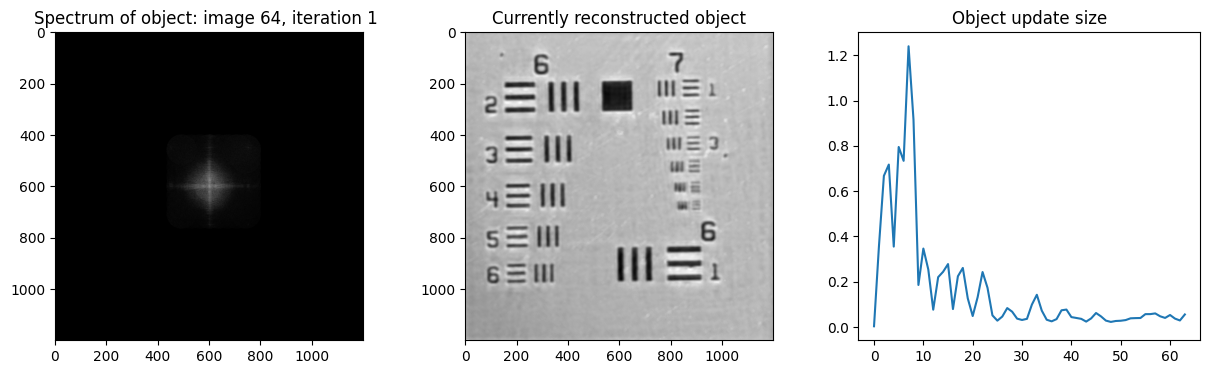

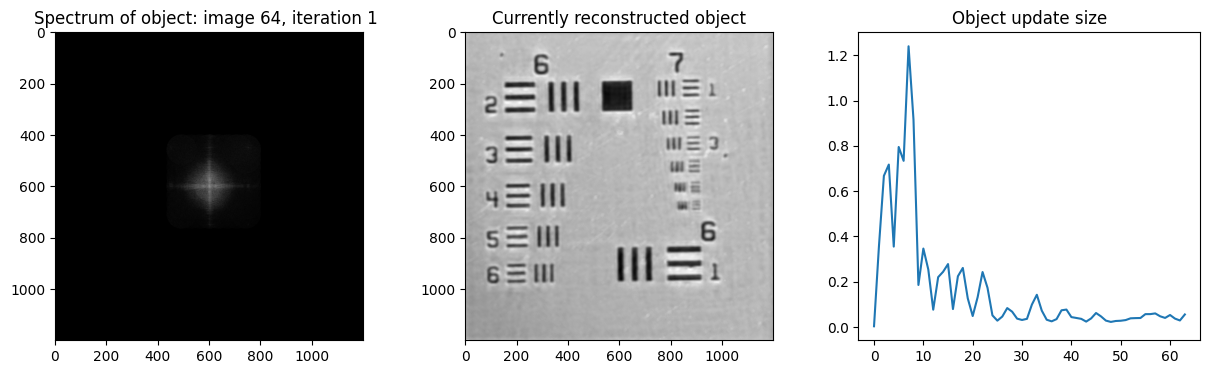


 Reconstruction Done!


In [3]:
# Main FPM reconstruction. Set up for square, grayscale images

import importlib 
importlib.reload(fpm)

# Load image data into an array
data_path = 'data/usaf_1'
grid_size = 8 # 1 -> 16, determines how many images to reconstruct with, beyond 12x12 grid images are mostly useless
img_size = 300 # Size of low res image (original or crop)
crop_x = 0 # From left
crop_y = 0 # From top

num_images = grid_size**2
images = np.zeros((img_size,img_size,num_images)) # Initialise array for storing images
brightfield = np.array(Image.open(os.path.join(data_path,'brightfield.png')))/256 # Brightfield image for reference
brightfield = brightfield[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop

for i in range(num_images): # ~ 2s to load all 256 images into array
    filename = os.path.join(data_path, f'image_{i}.png') # Construct path
    img = np.array(Image.open(filename))/255 # Open image and scale range to 0-1
    # img = img - np.min(img) # Normalise (this is not good since it increases effects of high frequencies / wide illumination images)
    # img = img / np.max(img)
    img = img[crop_y:crop_y+img_size,crop_x:crop_x+img_size] # Crop
    images[:,:,i] = img

# Experiment parameters
x_coords, y_coords = fpm.LED_spiral(grid_size, x_offset = 0, y_offset = 1) # LED coordinates in sequence
# (Offsets don't matter for reconstruction since we use distance from central LED)
LED2SAMPLE = 54 # Distance from LED array to the sample, 54mm (larger distance leads to closer overlapping Fourier circles, optimal 40-60%)
LED_P = 3.3 # LED pitch, mm
N_GLASS = 1.52 # Glass refractive index
NA = 0.1 # Objective numerical aperture
PIX_SIZE = 1090e-9 # Pixel size on object plane, m, 1090nm for 3D printed microscope (directly measured), 862nm for old data
WLENGTH = 550e-9 # Central wavelength of LED light, m

# Derived variables
f_cutoff = 2*NA/WLENGTH # Highest spatial frequency we can resolve in the optical system due to diffraction, lp/m
f_sampling = 1/PIX_SIZE # Sampling frequency (based on sensor pixel size and magnification), lp/m
x_abs = (x_coords - x_coords[0]) * LED_P # x distances of LEDs from center LED and optical axis
y_abs = (y_coords - y_coords[0]) * LED_P # y distances

# Size of object image (for given parameters upsampling is between 2 and 5 depending on grid_size)
# Can do seperately x and y if image is not square
obj_size = fpm.calculate_object_size(img_size, grid_size, LED2SAMPLE, LED_P, NA, WLENGTH, PIX_SIZE)

# Initial pupil function (binary mask)
# Nyquist sampling criterion: sampling_ratio >2 -> oversampling, sampling_ratio <2 -> undersampling (aliasing may occur)
sampling_ratio = f_sampling / f_cutoff 
# x,y is our normalised frequency domain for the images, cutoff frequency = 1 (both x and y)
x,y = np.meshgrid(np.linspace(-sampling_ratio,sampling_ratio,img_size), np.linspace(-sampling_ratio,sampling_ratio,img_size))
theta,r = np.arctan2(y,x), np.sqrt(x**2 + y**2) # Polar coordinates
pupil_radius = (1/sampling_ratio) * (img_size/2) # Diagnostics
pupil = r<1 # Binary mask for frequencies below cutoff frequency (higher frequencies cannot be resolved due to diffraction)

# Initial object estimate (using first image)
img = np.sqrt(images[:,:,0]) # Amplitude of central image
F_img = fpm.FT(img) # Fourier transformed image (with shift)
F_img = F_img * pupil # Apply pupil function
pad_width = int((obj_size - img_size) / 2) # Padding to make correct size
obj = np.pad(F_img,pad_width,'constant',constant_values=0) # Initial object in frequency domain

# Create fig and axes for plotting
fig, axes = plt.subplots(1,3,figsize=(15,4))

# Set parameters for reconstruction algorithm
options = {
    'max_iter': 1, # Number of iterations
    'alpha': 5, # Regularisation parameter for object update, <10
    'beta': 1, # Regularisation parameter for pupil update, >1
    'plot_mode': 3, # 0, off; 2, plot every image; 3, plot every iteration (notebook version)
    'LED_correction': False, # Adjust LED positions (kx,ky)
}

# Reconstruction with calculated kx and ky (quickstart)
kx,ky = fpm.calculate_fourier_positions(x_abs, y_abs, LED2SAMPLE, WLENGTH, PIX_SIZE, img_size)
rec_obj,rec_pupil,kx_updated,ky_updated = fpm.reconstruct_V1(images, kx, ky, obj, pupil, options, fig, axes)
# np.save(os.path.join(data_path,'kx_updated'),kx_updated)
# np.save(os.path.join(data_path,'ky_updated'),ky_updated)

# # Reconstruction with loaded / optimal kx and ky (optimal values depend on crop size)
# kx = np.load(os.path.join(data_path,'kx_updated.npy'))
# ky = np.load(os.path.join(data_path,'ky_updated.npy'))
# rec_obj,rec_pupil,_,_ = reconstruct(images, kx, ky, obj, pupil, options, fig, axes)

Plotting and save results

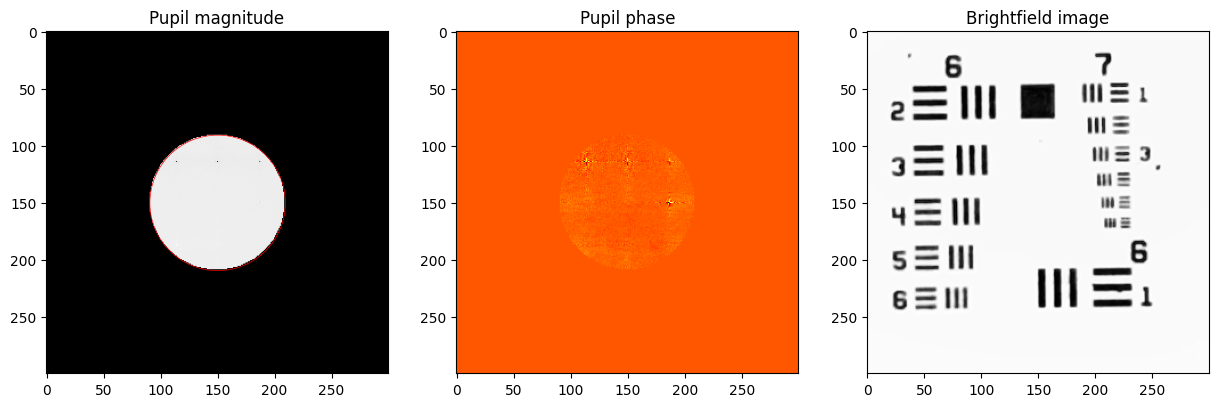

In [4]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15,15))

# Recovered object
obj_mag = np.abs(rec_obj) # Magnitude
obj_arg = np.angle(rec_obj) # Phase

# Recovered pupil
pupil_mag = np.abs(rec_pupil)
pupil_arg = np.angle(rec_pupil)

# # Show object
# axes[0].imshow(obj_mag,cmap='gray')
# axes[0].set_title('Object magnitude')
# axes[1].imshow(obj_arg, cmap='hot') # Heatmap for phase information
# axes[1].set_title('Object phase')

# Show pupil
axes[0].imshow(pupil_mag,cmap='gray')
axes[0].set_title('Pupil magnitude')
axes[1].imshow(pupil_arg, cmap='hot') # Heatmap for phase information
axes[1].set_title('Pupil phase')
circle = patches.Circle((150,150),radius=pupil_radius,linewidth =0.5, edgecolor='red',facecolor='none')
axes[0].add_patch(circle) # Ensure pupil radius is correct

# Show brighfield
axes[2].imshow(brightfield, cmap='gray')
axes[2].set_title('Brightfield image')

######################

# Save results (object)
obj_mag = obj_mag / np.max(np.abs(obj_mag)) # Normalise
obj_mag = (obj_mag * 255).astype(np.uint8)
obj_mag = Image.fromarray(obj_mag)
obj_mag.save('results/recent/magnitude.png')

obj_arg = plt.cm.hot(obj_arg)  # Necessary for saving image
obj_arg = (obj_arg * 255).astype(np.uint8)
obj_arg = Image.fromarray(obj_arg)
obj_arg.save('results/recent/phase.png',format='PNG')

bf = Image.open(os.path.join(data_path,'brightfield.png'))
bf.save('results/recent/brightfield.png')


Testing zone

Text(0.5, 1.0, 'LED positions (original and corrected)')

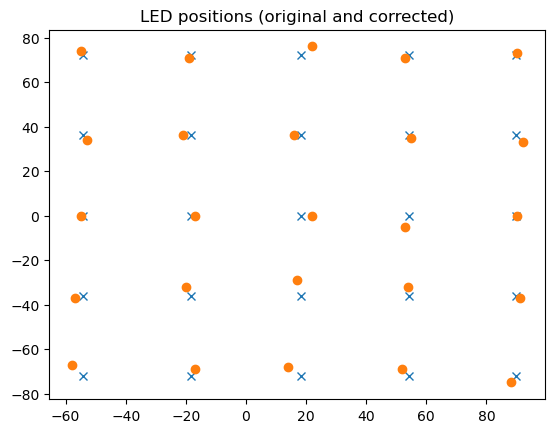

In [17]:
# Show LED positions (orignal and corrected)
plt.plot(kx,ky,'x') # Original LED positions
plt.plot(kx_updated,ky_updated,'o') # Corrected LED positions
plt.title('LED positions (original and corrected)')

# # Plot and inspect an image
# img = images[:,:,1]
# fig, axes = plt.subplots(1, 2, figsize=(15,15))
# axes[0].imshow(np.log(np.abs(FT(img)) + 1), cmap='gray') # Show FT with log scale
# # axes[1].imshow(img/np.max(img), cmap='gray') # Normalised image
# axes[1].imshow(img, cmap='gray') # Regular image
# print(np.max(img)*256 - np.min(img)*256) # Dynamic range of image
# print(np.std(img)*1000) # Not a great metric due to small range

# # Plot dynamic range vs image number
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:50,:50,i]
#     img_ranges[i] = (np.max(img) - np.min(img))*256
#     # img_ranges[i] = np.std(img)*1000
# plt.plot(img_ranges, label='image range - small crop')
# plt.xlabel('Image number')
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:,:,i]
#     img_ranges[i] = (np.max(img) - np.min(img))*256
#     # img_ranges[i] = np.std(img)*1000
# plt.plot(img_ranges, label='image range - large crop')
# # plt.axhline(np.min(img_ranges)*5)
# plt.xlabel('Image number')
# plt.legend()
# plt.show()

# # Dynamic range heat map
# threshold = 30 # Set to 0 to see every image in heatmap
# # Initialize dynamic ranges and define a 2D grid size based on your x, y locations
# img_ranges = np.zeros(num_images)
# for i in range(num_images):
#     img = images[:, :, i]
#     max_val = np.max(img) * 256
#     min_val = np.min(img) * 256
#     img_ranges[i] = max_val - min_val  # Store the dynamic range for each image
# # Create a 2D heatmap based on x, y coordinates
# heatmap = np.zeros((np.max(y_coords)+1, np.max(x_coords)+1))
# good_images = np.zeros(num_images) # At most will have num_images good images
# for i in range(num_images):
#     if img_ranges[i] >= threshold:
#         heatmap[y_coords[i], x_coords[i]] = img_ranges[i]  # Assign the dynamic range value at (x, y)
#         good_images[i] = i # Remember image number
#     else:
#         good_images[i] = None # Use none to avoid ambiguity with 0
# print(good_images)   
# # Plot the heatmap
# plt.imshow(heatmap, cmap='hot', origin='lower')
# plt.colorbar(label='Dynamic Range')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Dynamic Range Heatmap')
# plt.show()